In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys

sys.path.append("../")

from src.data_processing import DataProcessing

pd.options.display.max_columns = 100

# Data Loading and processing


In [18]:
df = pd.read_csv("../data/transfers.csv")
dp = DataProcessing(df)
df = dp.process_data()

In [19]:
df.head()

,season,team_id,counter_team_id,team_name,counter_team_name,team_country,counter_team_country,total_fee,is_loan
0,2009,3,1017,1. FC Köln,Hapoel Tel Aviv,Germany,Israel,0.0,0.0
1,2009,3,113,1. FC Köln,FC Carl Zeiss Jena,Germany,Germany,0.0,1.0
2,2009,3,17,1. FC Köln,Borussia Dortmund II,Germany,Germany,0.0,1.0
3,2009,3,2113,1. FC Köln,Career break,Germany,Career break,0.0,0.0
4,2009,3,3709,1. FC Köln,Getafe CF,Germany,Spain,750000.0,0.0


# Graph Modeling


We will model the dataset as one graph per season where

- Each club is a node and each transfer is an edge.
- The weight of the edge will be the amount of money paid for the transfer.
- We will add a direction to the edges, from the club that sells the player to the club that buys the player.
- We will add a property to the nodes that will be the number of players that have been transferred in and out of the club.
- We will also model loans as edges, but we will not add a weight to them.
- We will add a property to the edges that will be the type of transfer (loan or permanent).


In [20]:
seasons = df["season"].unique()
seasons

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021])

## Working on one season


In [ ]:
df_season = df[df["season"] == 2021]
df_season

,season,team_id,counter_team_id,team_name,counter_team_name,team_country,counter_team_country,total_fee,is_loan
45773,2021,3,105,1. FC Köln,SV Darmstadt 98,Germany,Germany,0.0,0.0
45774,2021,3,1096,1. FC Köln,Royal Antwerp FC,Germany,Belgium,2000000.0,0.0
45775,2021,3,16,1. FC Köln,Borussia Dortmund,Germany,Germany,0.0,1.0
45776,2021,3,162,1. FC Köln,AS Monaco,Germany,France,6500000.0,0.0
45777,2021,3,1622,1. FC Köln,FC Viktoria Köln,Germany,Germany,0.0,0.0
...,...,...,...,...,...,...,...,...,...
48690,2021,9899,681,Real Sociedad B,Real Sociedad,Spain,Spain,0.0,0.0
48691,2021,990,631,Coventry City,Chelsea FC,England,England,0.0,1.0
48692,2021,990,1269,Coventry City,PEC Zwolle,England,Netherlands,0.0,0.0
48693,2021,991,1123,Milton Keynes Dons,Norwich City,England,England,0.0,1.0


In [ ]:
di_graph = nx.from_pandas_edgelist(
    df_season,
    source="team_name",
    target="counter_team_name",
    edge_attr=["total_fee", "is_loan"],
)

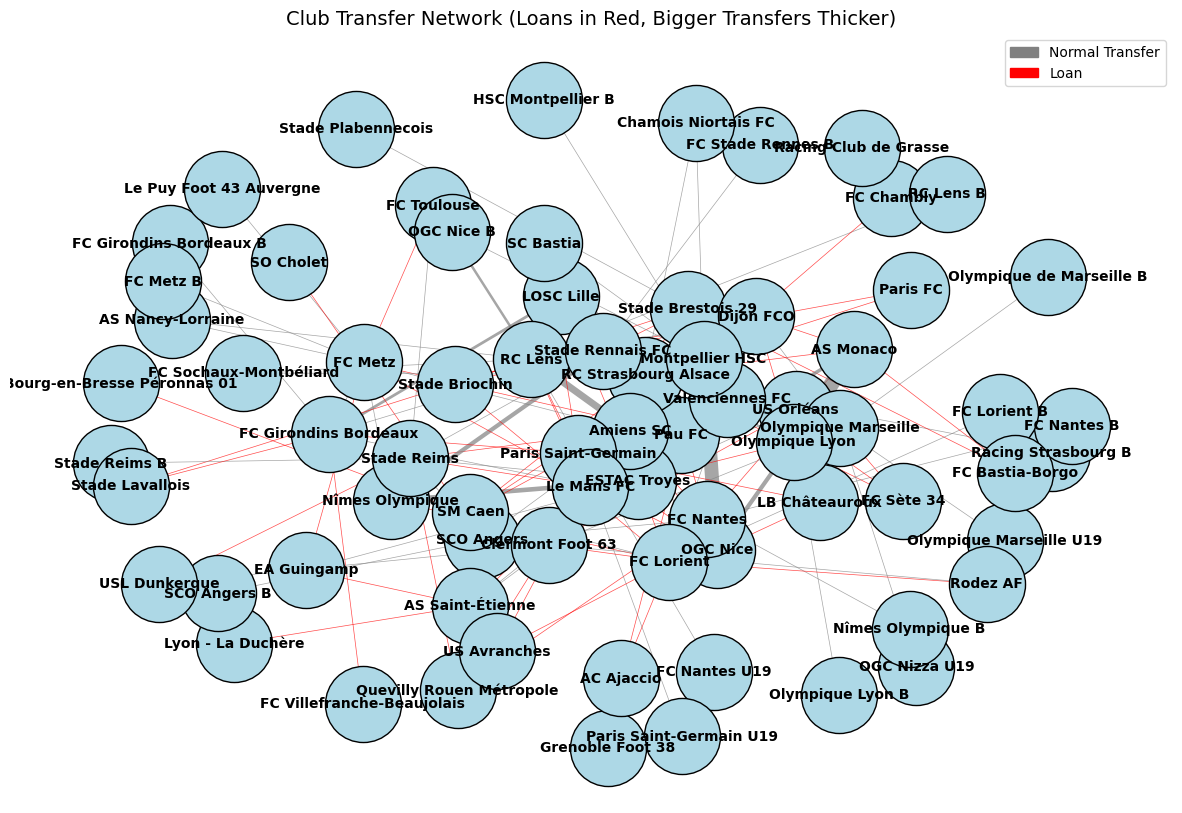

In [ ]:
# Visualize the directed sub graph
club_to_visualize = df_season[df_season["team_country"] == "France"][
    "team_name"
].unique()
sub_graph = di_graph.subgraph(club_to_visualize)


pos = nx.spring_layout(
    sub_graph, seed=42, k=0.8
)  # k controls spacing (higher = more spread out)

# Edges
edge_colors = [
    "red" if d["is_loan"] == 1 else "gray" for _, _, d in sub_graph.edges(data=True)
]
edge_weights = [
    max(d["total_fee"] / 1e6, 0.5) for _, _, d in sub_graph.edges(data=True)
]  # Scale thickness

plt.figure(figsize=(15, 10))  # Bigger figure for better visibility

nx.draw_networkx_nodes(
    sub_graph, pos, node_color="lightblue", node_size=3000, edgecolors="black"
)
nx.draw_networkx_edges(
    sub_graph, pos, edge_color=edge_colors, width=edge_weights, alpha=0.7, arrows=True
)
nx.draw_networkx_labels(sub_graph, pos, font_size=10, font_weight="bold")

import matplotlib.patches as mpatches

normal_patch = mpatches.Patch(color="gray", label="Normal Transfer")
loan_patch = mpatches.Patch(color="red", label="Loan")
plt.legend(handles=[normal_patch, loan_patch], loc="upper right")

plt.title("Club Transfer Network (Loans in Red, Bigger Transfers Thicker)", fontsize=14)
plt.axis("off")  # Hide axes
plt.show()